In [8]:

import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle as pkl
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools
import hhsignal
import importlib
from tqdm.notebook import tqdm, trange
# other options
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'w'
np.set_printoptions(suppress=True)
from importlib import reload

import oscdetector as od

In [9]:
summary_obj = hhtools.SummaryLoader("../gen_three_pop_samples_repr/data")

srate = 2000

key_names = ("fpop", "spop")
amp_range_set = [
    dict(fpop=[[]], spop=[[]]), # 1
    dict(fpop=[[]], spop=[[]]), # 2
    dict(fpop=[[20, 30], [40, 50]],
         spop=[[20, 30]]), # 3
    dict(fpop=[[30, 40], [50, 70]],
         spop=[[30, 40]]), # 4
    dict(fpop=[[], [60, 70]],
         spop=[[25, 35], [60, 70]]), # 5 -> tuned
    dict(fpop=[[50, 70]], 
         spop=[[20, 40], [50, 70]]), # 6
    dict(fpop=[[60, 70]],
         spop=[[60, 70]]), # 7
    dict(fpop=[[30, 40], [60, 70]],
         spop=[[30, 40]]), # 8 -> tuned
]

# frequency range are determined based on fourier transform result

Load cache file


# Example

In [5]:
cid = 5
detail_data = summary_obj.load_detail(cid-1, 10)
psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, frange=(10, 100), mbin_t=0.01, wbin_t=0.5, srate=srate)

[[60, 70]]


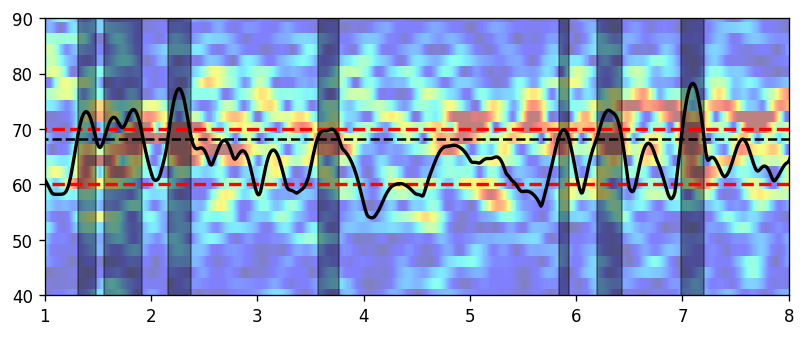

In [7]:
ntp, tp_label = 1, "fpop"

amp_range = amp_range_set[cid-1][tp_label]
# amp_range = [[20, 30], [65, 75]]
amp_range = [[60, 70]]
# amp_range = [[25, 35]]
print(amp_range)

plt.figure(figsize=(8, 3))
hhtools.imshow_xy(psd_set[ntp], x=tpsd, y=fpsd, interpolation="none", cmap="jet", alpha=0.5)

opt = dict(color="r", linestyle="--", linewidth=2)
for r in amp_range:
    plt.hlines(r[0], tpsd[0], tpsd[-1], **opt)
    plt.hlines(r[1], tpsd[0], tpsd[-1], **opt)
    
r = amp_range[0]
y = psd_set[1][(fpsd >= r[0]) & (fpsd <= r[1]), :].mean(axis=0)
yn = (y - y.mean())/y.std()*5 + np.average(r)
plt.plot(tpsd, yn, c='k', lw=2)

bd_idy, yth = od.pick_osc(yn, min_len=2, q=75)
# bd_idy, yth = pick_osc(yn, min_len=2, q=20, reversed=True)
plt.hlines(yth, tpsd[0], tpsd[-1], color='k', linestyle='--')

for bd in bd_idy:
    x0, x1 = tpsd[bd[0]], tpsd[bd[1]]
    plt.fill_betweenx([0, 100], [x0, x0], [x1, x1], color='k', alpha=0.4)

plt.ylim([40, 90])
plt.xlim([1, 8])
plt.show()

# Oscillation motif sample

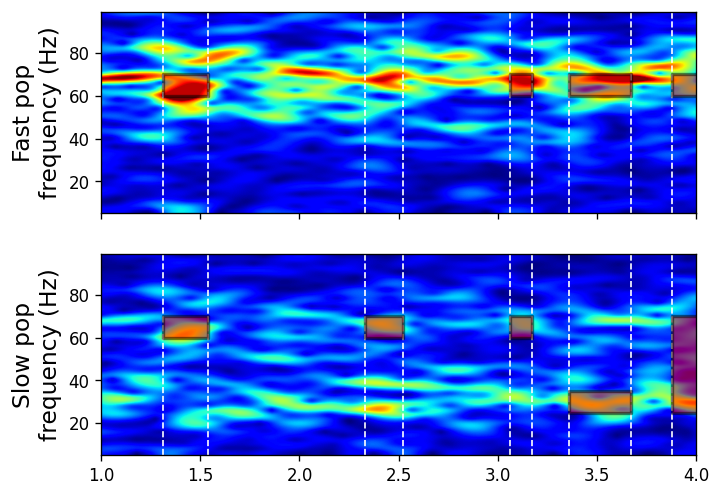

In [172]:
cid =5 
amp_range = amp_range_set[cid-1]

detail_data =summary_obj.load_detail(cid-1, 20)
psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, mbin_t=0.01)
words = od.compute_osc_bit(psd_set[1:], fpsd, tpsd, amp_range, q=80, min_len=2, cat_th=4)

tp_labels = ("Fast pop", "Slow pop")

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

for i in range(2):
    plt.axes(axs[i])
    hhtools.imshow_xy(psd_set[i+1], x=tpsd, y=fpsd, cmap="jet", interpolation="bicubic", vmax=0.8)
    plt.ylabel("%s\nfrequency (Hz)"%(tp_labels[i]), fontsize=14)
# axs[0].set_xticklabels([])
yl_p = plt.ylim()

osc_motif = od.get_motif_boundary(words)
for n in range(len(osc_motif)):
    idx = od.dec2bin(osc_motif[n]["id"], 4)
    nl = osc_motif[n]["range"]
    xl = [tpsd[nl[0]], tpsd[nl[1]]]

    for i in range(2):
        tp = "fpop" if i == 0 else "spop"
        if idx[2*i] and idx[2*i+1]:
            yl = [amp_range[tp][0][0], amp_range[tp][1][1]]
        else:
            if idx[2*i]:
                yl = amp_range[tp][0]
            elif idx[2*i+1]:
                yl = amp_range[tp][1]
            else:
                yl = []
        
        if not yl:
            continue
        else:
            axs[i].fill_between(xl, [yl[0], yl[0]], [yl[1], yl[1]], facecolor="r", alpha=0.5, edgecolor="k", linewidth=2)
    
    for i in range(2):
        axs[i].plot([xl[0], xl[0]], yl_p, 'w--', lw=1, zorder=0)
        axs[i].plot([xl[1], xl[1]], yl_p, 'w--', lw=1, zorder=0)
    
axs[0].set_ylim(yl_p)
axs[1].set_xlim([1, 4])

plt.show()

# Oscillation motif statistics

In [10]:
target_cid = [5, 8]
word_counts = np.zeros((len(target_cid), 16))
for nc, cid in enumerate([5, 8]):
    amp_range = amp_range_set[cid-1]
    
    for i in trange(200):
        detail_data = summary_obj.load_detail(cid-1, i)
        psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, mbin_t=0.01, wbin_t=0.5)
        # words = od.compute_osc_bit(psd_set[1:], fpsd, tpsd, amp_range, q=75, min_len=2, cat_th=2)
        words = od.compute_osc_bit(psd_set[1:], fpsd, tpsd, amp_range, q=80, min_len=2, cat_th=2)
        
        word_counts[nc] += od.count_motif(words)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [15]:
plt.figure(figsize=(5, 2.5))
plt.plot(word_counts[0], 'o-', label="cid5")
plt.plot(word_counts[1], 'o-', label="cid8")
plt.xticks(np.arange(16), od.get_motif_labels(), rotation=60)
plt.legend(loc="upper left", edgecolor="none")

plt.show()